In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from unidip import UniDip
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder


def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    '''
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def plot_MoG_bounds(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    plot_MoG=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if plot_MoG:
            confidence_ellipse(x, z, axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(maxptp, z, axes[1], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
    
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-50, x.max()+50)
            axes[0].set_ylim(z.min()-100, z.max()+100)
            axes[1].set_xlim(0, maxptp.max()+30)
            axes[1].set_ylim(z.min()-100, z.max()+100)
        else:    
            axes[0].set_xlim(data[:,0].min()-10, data[:,0].max()+10)
            axes[0].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
            axes[1].set_xlim(data[:,2].min()-.5, data[:,2].max()+.5)
            axes[1].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('log-ptp')
    axes[1].set_ylabel('z (um)')
    if plot_MoG:
        axes[1].set_title(f'n_units = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1)
        axes[1].spines[ax].set_linewidth(1)

    plt.tight_layout()
    plt.show()

### load data

In [42]:
# triaged_spike_index = np.load('/mnt/3TB/yizi/outputs_recording_static/subtraction_threshold_5/triaged_spike_index.npy')
# triaged_spike_features = np.load('/mnt/3TB/yizi/outputs_recording_static/subtraction_threshold_5/triaged_localization_results.npy')
# spike_times, spike_channels = triaged_spike_index.T
# x, z, maxptp = triaged_spike_features.T
# n_channels = np1_channel_map.shape[0]

In [52]:
spike_index = np.load('/mnt/3TB/yizi/outputs_recording_static/subtraction_threshold_5/spike_index.npy')
spike_features = np.load('/mnt/3TB/yizi/outputs_recording_static/subtraction_threshold_5/localization_results.npy')
np1_channel_map = np.load('/mnt/3TB/yizi/outputs_recording_static/geom.npy')
spike_times, spike_channels = spike_index.T
x, z, maxptp = spike_features.T
n_channels = np1_channel_map.shape[0]

In [53]:
scales=(1, 1, 50)
log_c=5
spike_features = np.c_[x * scales[0], z * scales[1], np.log(log_c + maxptp) * scales[2]]

In [46]:
from sklearn.cluster import DBSCAN

multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        dbscan = DBSCAN(eps=20, min_samples=2).fit(sub_spike_features)
        n_gaussians = len(np.unique(dbscan.labels_))
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = BayesianGaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='k-means++', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 1 has 2 modes ...
channel 28 has 2 modes ...
channel 36 has 2 modes ...
channel 42 has 2 modes ...
channel 43 has 2 modes ...
channel 45 has 2 modes ...
channel 49 has 2 modes ...
channel 55 has 2 modes ...
channel 69 has 2 modes ...
channel 70 has 2 modes ...
channel 73 has 3 modes ...
channel 74 has 2 modes ...
channel 79 has 2 modes ...
channel 100 has 2 modes ...
channel 109 has 2 modes ...
channel 124 has 2 modes ...
channel 135 has 2 modes ...
channel 142 has 2 modes ...
channel 143 has 2 modes ...
channel 145 has 2 modes ...
channel 156 has 2 modes ...
channel 159 has 3 modes ...
channel 211 has 2 modes ...
channel 264 has 2 modes ...
channel 270 has 2 modes ...
channel 272 has 2 modes ...
channel 273 has 2 modes ...
channel 276 has 3 modes ...
channel 278 has 2 modes ...
channel 280 has 2 modes ...
channel 281 has 3 modes ...
channel 284 has 2 modes ...
channel 289 has 2 modes ...
channel 295 has 2 modes ...
channel 297 has 2 modes ...
channel 298 has 2 modes ...
channe

### split 1

In [54]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
p_val = 0.01
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    sub_x, sub_z, sub_maxptp = sub_spike_features.T
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        x_modes = UniDip(np.msort(sub_x), alpha=p_val).run()
        n_modes_x = len(x_modes)
        z_modes = UniDip(np.msort(sub_z), alpha=p_val).run()
        n_modes_z = len(z_modes)
        ptp_modes = UniDip(np.msort(sub_maxptp), alpha=p_val).run()
        n_modes_ptp = len(ptp_modes)
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = BayesianGaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              n_init=10,
                              covariance_type='full',
                              init_params='k-means++', 
                              # init_params='random_from_data',
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 10 has 2 modes ...
channel 19 has 2 modes ...
channel 40 has 2 modes ...
channel 70 has 2 modes ...
channel 124 has 3 modes ...
channel 211 has 2 modes ...
channel 231 has 2 modes ...
channel 249 has 2 modes ...
channel 253 has 2 modes ...
channel 258 has 2 modes ...
channel 293 has 2 modes ...
channel 297 has 2 modes ...
channel 324 has 2 modes ...
channel 339 has 2 modes ...
channel 347 has 2 modes ...
channel 376 has 3 modes ...
channel 379 has 3 modes ...


In [28]:
channel = 19
sub_spike_times = spike_times[spike_channels == channel]
sub_spike_features = spike_features[spike_channels == channel]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

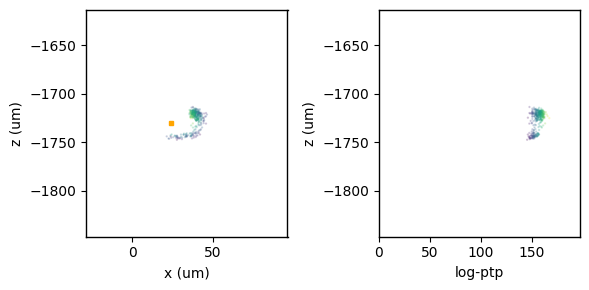

In [29]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=[channel], 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=False,
    figure_size=(6,3)
)

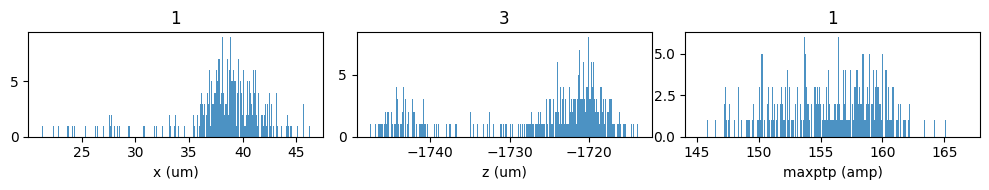

In [30]:
p_val = 0.05,
x_modes = UniDip(np.msort(sub_x), alpha=p_val).run()
n_modes_x = len(x_modes)
z_modes = UniDip(np.msort(sub_z), alpha=p_val).run()
n_modes_z = len(z_modes)
ptp_modes = UniDip(np.msort(sub_maxptp), alpha=p_val).run()
n_modes_ptp = len(ptp_modes)
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [31]:
# initialize MoG using kmeans
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_features)
sub_labels = sub_gmm.predict(sub_spike_features)

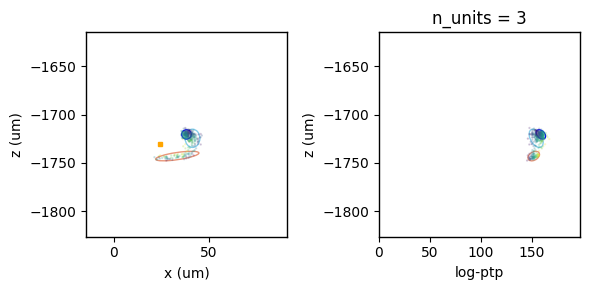

In [32]:
plot_MoG_bounds(
    data=sub_spike_features, 
    labels=sub_labels, 
    labels_display=np.unique(sub_labels), 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=True,
    figure_size=(6,3),
    n_spikes = 1_000
)

In [55]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='k-means++', 
                              # init_params='random_from_data',
                              warm_start=False, 
                              verbose=0)
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [56]:
spike_labels = post_split_gmm.predict(spike_features)
# spike_probs = post_split_gmm.predict_proba(spike_features)

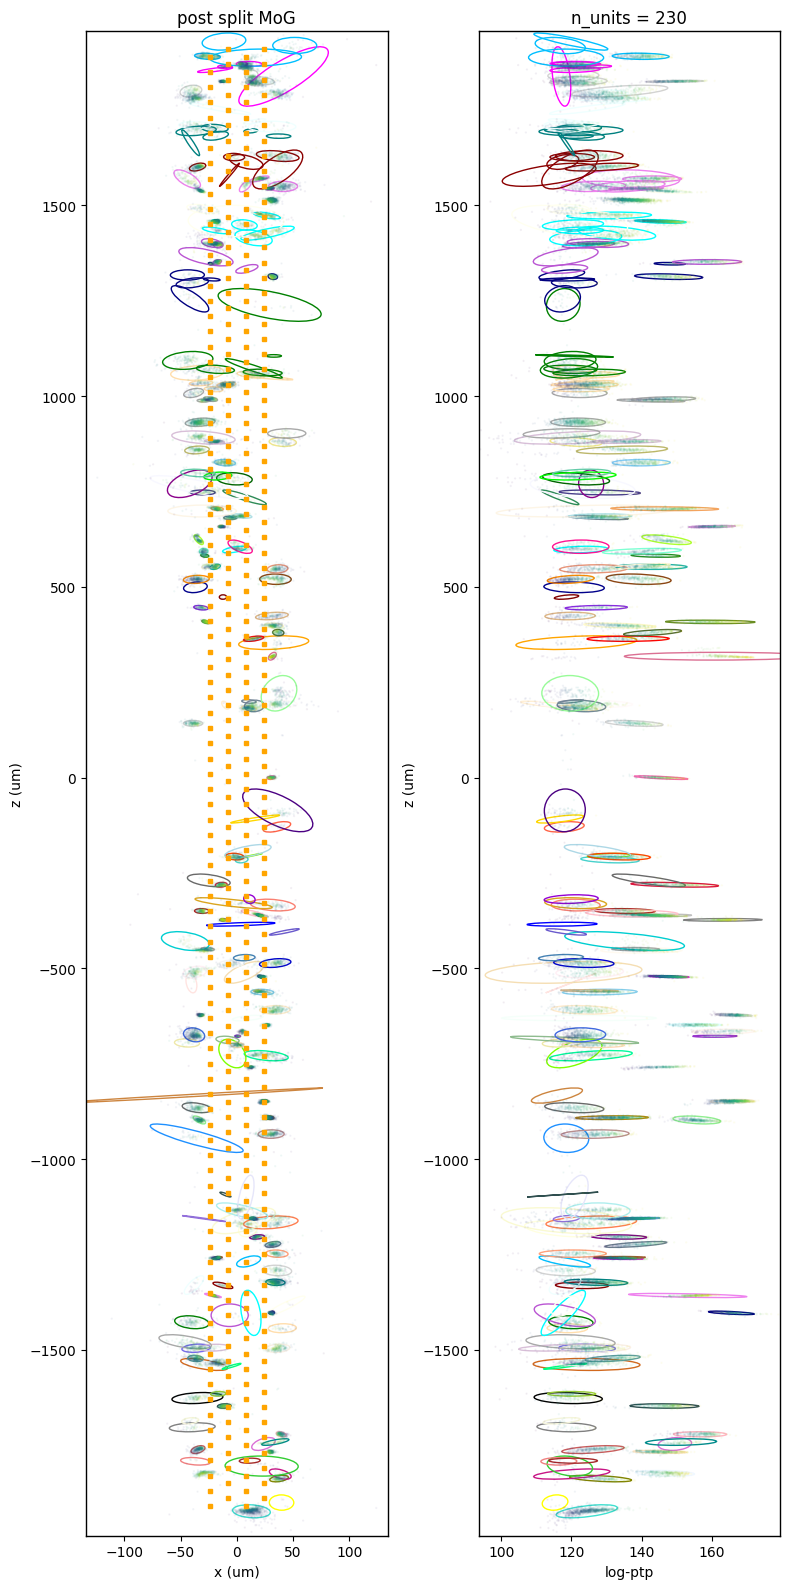

In [57]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [58]:
gmm_name = '../pretrained/simulated/post_split_gmm'
np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

post_split_spike_train = np.c_[spike_times, spike_labels]
np.save(gmm_name + '_spike_train.npy', post_split_spike_train, allow_pickle=False)

### merge 1

In [59]:
def kl_mvn(mu0, mu1, S0, S1):
    N = mu0.shape[0]
    inv_S1 = np.linalg.inv(S1)
    diff = mu1 - mu0
    tr_term   = np.trace(inv_S1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) 
    quad_term = diff.T @ np.linalg.inv(S1) @ diff 
    return .5 * (tr_term + det_term + quad_term - N) 

def symmetric_kl(mu0, mu1, S0, S1):
    kl1 = kl_mvn(mu0, mu1, S0, S1)
    kl2 = kl_mvn(mu1, mu0, S1, S0)
    return np.mean([kl1, kl2])

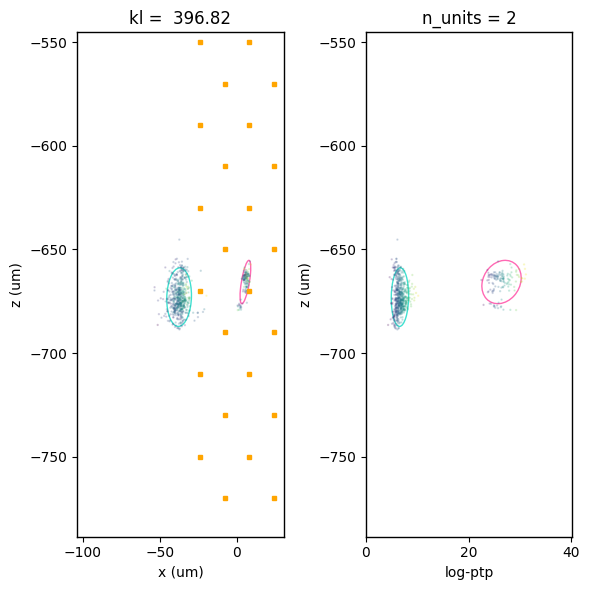

In [9]:
labels = [70, 71] 

kl = symmetric_kl(mu0 = post_split_gmm.means_[labels[0]], 
       mu1 = post_split_gmm.means_[labels[1]], 
       S0 = post_split_gmm.covariances_[labels[0]], 
       S1 = post_split_gmm.covariances_[labels[1]])

plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=labels, 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [77]:
mask = np.logical_or(spike_labels == labels[0], spike_labels == labels[1])
sub_spike_times = spike_times[mask]
sub_spike_features = spike_features[mask]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

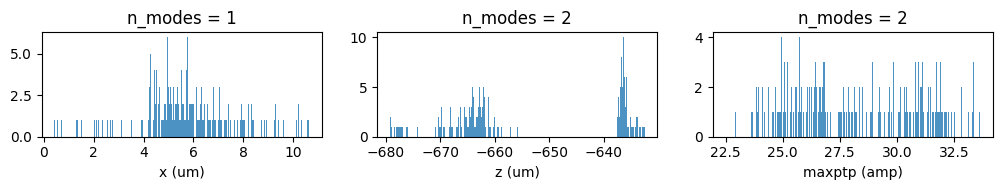

In [78]:
p_val = 0.05,
n_modes_x = len(UniDip(np.msort(sub_x), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_z), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_maxptp), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(f'n_modes = {n_modes_x}')
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(f'n_modes = {n_modes_z}')
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(f'n_modes = {n_modes_ptp}')
plt.tight_layout()
plt.show()

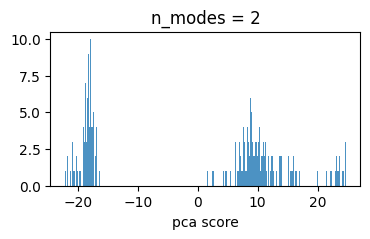

In [79]:
pca = PCA(n_components=1, svd_solver='full')
features_transformed = pca.fit_transform(sub_spike_features).flatten()

p_val = 0.05
# n_tests = 1000
n_modes = len(UniDip(np.msort(features_transformed), alpha=p_val).run())
plt.figure(figsize=(4,2))
plt.hist(features_transformed, 300, alpha=.8)
plt.xlabel('pca score')
plt.title(f'n_modes = {n_modes}');

### roll out on all pairs of gaussians ...

In [60]:
def pairwise_symmetric_kl(means, covs):
    m = len(means)
    D = np.ones((m,m)) * np.inf
    pairs = []
    for i in range(m):
        for j in range(m):
            if i != j:
                if set([i,j]) not in pairs:
                    pairs.append(set([i,j]))
                    kl = symmetric_kl(mu0 = means[i], 
                                       mu1 = means[j], 
                                       S0 = covs[i], 
                                       S1 = covs[j])
                    D[i, j] = kl
                    if np.logical_and(i % 50 == 0, j % 100 == 0):
                        print(f'calc kl for pair ({i}, {j}) ...')
            elif i == j:
                D[i, j] = np.inf  # exclude self-connection
    return D

In [61]:
kl_div = pairwise_symmetric_kl(post_split_gmm.means_, post_split_gmm.covariances_)

calc kl for pair (0, 100) ...
calc kl for pair (0, 200) ...
calc kl for pair (50, 100) ...
calc kl for pair (50, 200) ...
calc kl for pair (100, 200) ...
calc kl for pair (150, 200) ...


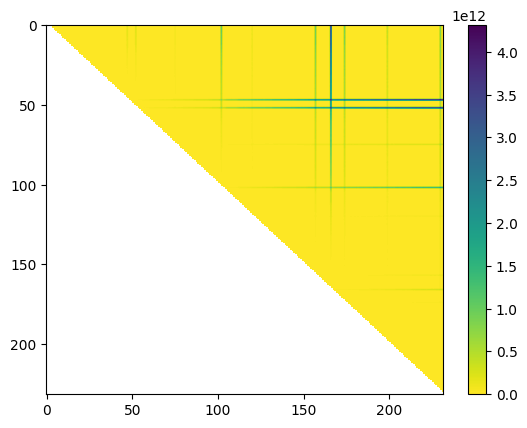

In [62]:
plt.imshow(kl_div, aspect='auto', cmap='viridis_r')
plt.colorbar()
plt.show()

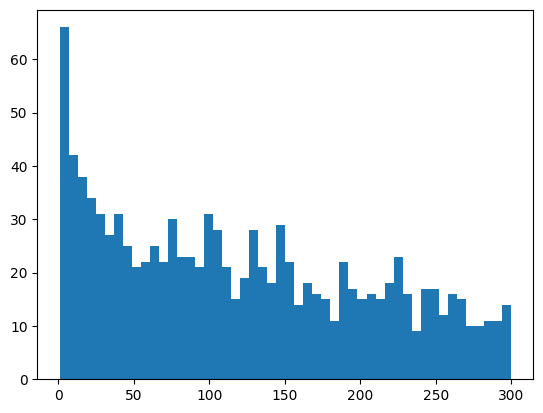

In [63]:
plt.hist(kl_div[kl_div < 300].flatten(), 50);

In [14]:
np.argwhere(np.logical_and(kl_div > 29, kl_div < 30))

array([[ 71,  74],
       [ 94,  95],
       [167, 170],
       [202, 210],
       [205, 208]])

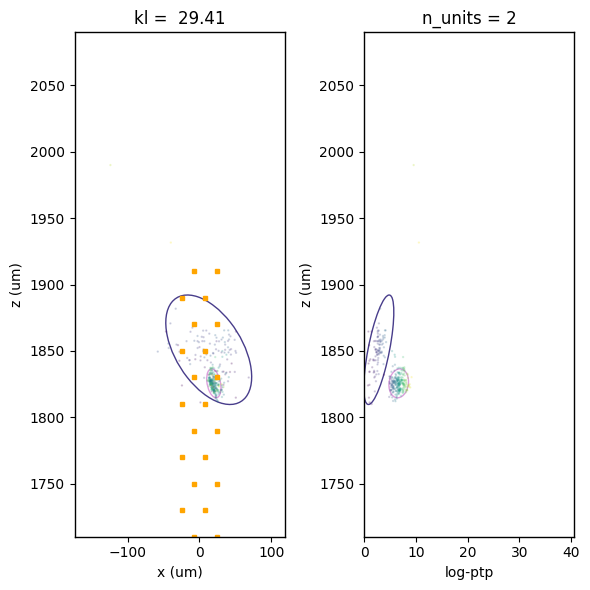

In [46]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=[232, 242], 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl_div[232, 242]: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [64]:
merge_candidates = np.argwhere(kl_div < 5) 

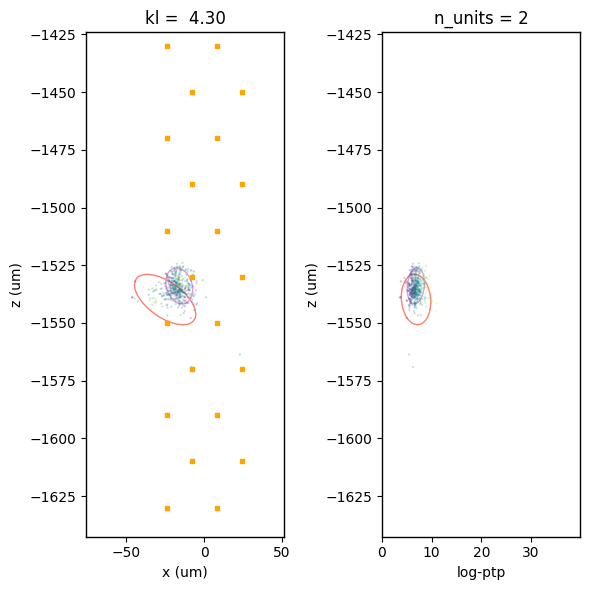

In [16]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=merge_candidates[0], 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels), 
    title=f'kl = {kl_div[merge_candidates[0][0], merge_candidates[0][1]]: .2f}',
    local=True,
    plot_MoG=True,
    figure_size=(6,6)
)

In [65]:
post_split_labels = spike_labels.copy()
pre_merge_labels = set(np.unique(post_split_labels)).difference(set(np.unique(merge_candidates)))
print(f'keep {len(pre_merge_labels)} gaussians and merge {len(np.unique(merge_candidates))} gaussians ...')

pre_merge_weights = np.vstack([post_split_gmm.weights_[i] for i in pre_merge_labels]).squeeze()
pre_merge_means = np.vstack([post_split_gmm.means_[i] for i in pre_merge_labels])
pre_merge_covariances = np.stack([post_split_gmm.covariances_[i] for i in pre_merge_labels])

pre_merge_gmm = GaussianMixture(n_components = len(pre_merge_weights), covariance_type='full')
pre_merge_gmm.weights_ = pre_merge_weights
pre_merge_gmm.means_ = pre_merge_means
pre_merge_gmm.covariances_ = pre_merge_covariances
pre_merge_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(pre_merge_covariances))

keep 154 gaussians and merge 78 gaussians ...


In [66]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(merge_candidates)
merge_cliques = sorted(nx.connected_components(G), key = len, reverse=True)

In [67]:
len(merge_cliques)

33

In [68]:
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []

for clique in merge_cliques:
    print('merging '+ str(clique) + ' ...')
    sub_spike_features = [] 
    for unit in clique:
        sub_spike_features.append([spike_features[post_split_labels == unit]])
    sub_spike_features = np.hstack(sub_spike_features).squeeze()
    sub_gmm = BayesianGaussianMixture(n_components=1, 
                                      init_params='k-means++',
                                      n_init=10)
    sub_gmm.fit(sub_spike_features)
    sub_labels = sub_gmm.predict(sub_spike_features)
    sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
    sub_weights_lst.append(sub_weights)
    sub_means_lst.append(sub_gmm.means_)
    sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

merging {144, 141, 142, 143} ...
merging {208, 209, 211, 205} ...
merging {24, 25, 22} ...
merging {44, 45, 46} ...
merging {97, 99, 100} ...
merging {138, 139, 140} ...
merging {163, 164, 159} ...
merging {161, 162, 165} ...
merging {192, 193, 197} ...
merging {216, 218, 221} ...
merging {2, 4} ...
merging {10, 12} ...
merging {18, 20} ...
merging {40, 37} ...
merging {65, 63} ...
merging {80, 82} ...
merging {83, 84} ...
merging {88, 91} ...
merging {92, 93} ...
merging {96, 95} ...
merging {106, 109} ...
merging {124, 127} ...
merging {128, 129} ...
merging {149, 150} ...
merging {153, 154} ...
merging {172, 175} ...
merging {177, 179} ...
merging {180, 182} ...
merging {187, 183} ...
merging {184, 186} ...
merging {217, 214} ...
merging {226, 223} ...
merging {227, 229} ...


In [69]:
post_merge_weights = np.vstack([pre_merge_gmm.weights_.reshape(-1,1), sub_weights.reshape(-1,1)]).flatten()
post_merge_means = np.vstack([pre_merge_gmm.means_, sub_means])
post_merge_covs = np.vstack([pre_merge_gmm.covariances_, sub_covs])

post_merge_gmm = GaussianMixture(n_components=len(post_merge_weights), 
                                 covariance_type='full')
post_merge_gmm.weights_ = post_merge_weights
post_merge_gmm.means_ = post_merge_means
post_merge_gmm.covariances_ = post_merge_covs
post_merge_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_merge_covs))

In [70]:
post_merge_labels = post_merge_gmm.predict(spike_features)
# post_merge_probs = post_merge_gmm.predict_proba(spike_features)

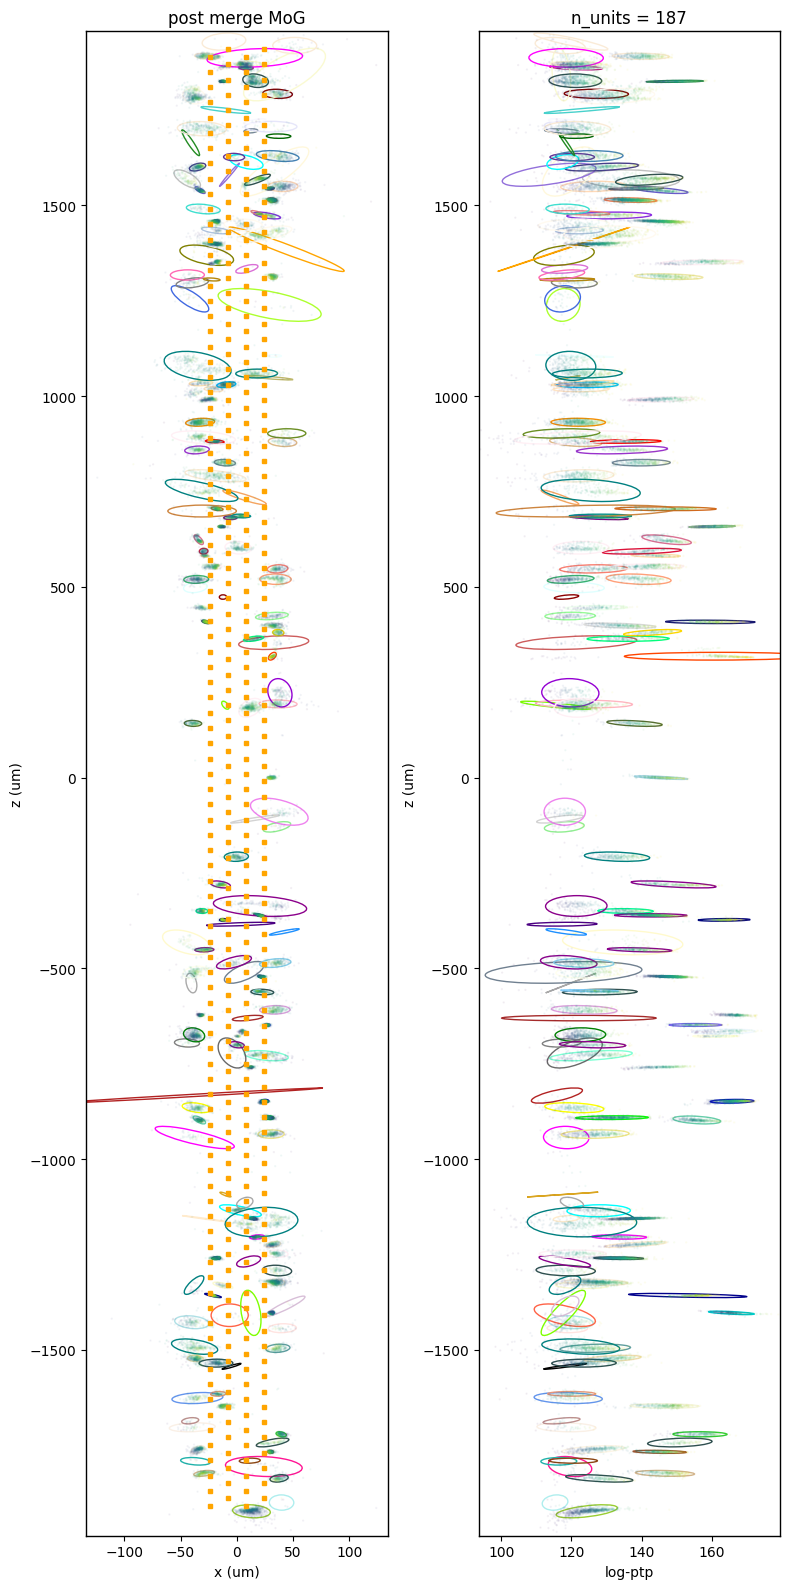

In [71]:
plot_MoG_bounds(
    data=spike_features, 
    labels=post_merge_labels, 
    labels_display=np.unique(post_merge_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post merge MoG'
)

In [72]:
gmm_name = '../pretrained/simulated/post_merge_gmm'
np.save(gmm_name + '_weights', post_merge_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_merge_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_merge_gmm.covariances_, allow_pickle=False)

post_merge_spike_train = np.c_[spike_times, post_merge_labels]
np.save(gmm_name + '_spike_train.npy', post_merge_spike_train, allow_pickle=False)